In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import os
import torch
import sys
sys.path.append("/data1/yang_liu/python_workspace/GSPL")

from tqdm.auto import tqdm
from functools import partial
from matplotlib import pyplot as plt
import json
from internal.dataparsers.colmap_dataparser import ColmapDataParser
import internal.utils.colmap as colmap_utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
torch.set_grad_enabled(False)
torch.set_printoptions(precision=16)

In [4]:
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.utils.sh_utils import SH2RGB

In [5]:
dataset_path = os.path.expanduser("../data/GauU_Scene/LFLS")

# 1. Load dataset

In [174]:
device = torch.device("cuda")
ckpt_path = "../outputs/citygsv2_lfls_coarse_sh2_t1/checkpoints/epoch=32-step=30000.ckpt"
ckpt = torch.load(ckpt_path, map_location="cpu")
bkgd_color = ckpt["hyper_parameters"]["background_color"]
model = GaussianModelLoader.initialize_model_from_checkpoint(
    ckpt,
    device=device,
)
model.freeze()
model.pre_activate_all_properties()
# initialize renderer
renderer = GaussianModelLoader.initialize_renderer_from_checkpoint(
    ckpt,
    stage="validate",
    device=device,
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))

Gaussian count: 9157137


In [175]:
# initialize dataset
dataparser_config = ckpt["datamodule_hyper_parameters"]["parser"]
dataset_path = os.path.join("../", ckpt["datamodule_hyper_parameters"]["path"])
dataparser_outputs = dataparser_config.instantiate(
    path=dataset_path,
    output_path=os.getcwd(),
    global_rank=0,
).get_outputs()
dataset = dataparser_outputs.train_set

appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 958, val set images: 120, loaded mask: 0
[WARNING depth scale of DJI_20240223162810_0005_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240223162816_0006_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307155130_0029_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307155135_0030_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307155136_0031_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307164705_0030_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307171150_0009_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307171214_0018_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307171220_0020_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20240307171223_0021_Zenmuse-L1-mission.JPG out of bou

In [176]:
c2w = torch.linalg.inv(torch.stack([cam.world_to_camera.T for cam in dataset.cameras]))

reorientation

In [177]:
# calculate the up direction of the scene
# NOTE: 
#   the calculated direction may not be perfect or even incorrect sometimes, 
#   in such a situation, you need to provide a correct up vector
up = -torch.mean(c2w[:, :3, 1], dim=0)
up = up / torch.linalg.norm(up)

rotation = ColmapDataParser.rotation_matrix(up, torch.tensor([0, 0, 1], dtype=up.dtype))
rotation_transform = torch.eye(4, dtype=up.dtype)
rotation_transform[:3, :3] = rotation
up, rotation_transform

(tensor([-0.1961847841739655, -0.7181289196014404, -0.6676843762397766]),
 tensor([[ 0.8841809630393982, -0.4239522516727448,  0.1961847841739655,
           0.0000000000000000],
         [-0.4239522516727448, -0.5518654584884644,  0.7181289196014404,
           0.0000000000000000],
         [-0.1961847841739655, -0.7181289196014404, -0.6676843166351318,
           0.0000000000000000],
         [ 0.0000000000000000,  0.0000000000000000,  0.0000000000000000,
           1.0000000000000000]]))

In [207]:
# reoriented_camera_centers = c2w[:, :3, 3] @ rotation_transform[:3, :3].T
reoriented_camera_centers = c2w[:, :3, 3]
# reoriented_point_cloud_xyz = model.get_xyz @ rotation_transform[:3, :3].T
reoriented_point_cloud_xyz = model.get_xyz.to(c2w.device)
point_rgbs = SH2RGB(model.get_features[:, 0]).clamp(0, 1).to(c2w.device) * 255.0

extract valid points

plot the scene, confirming that it shows in top view

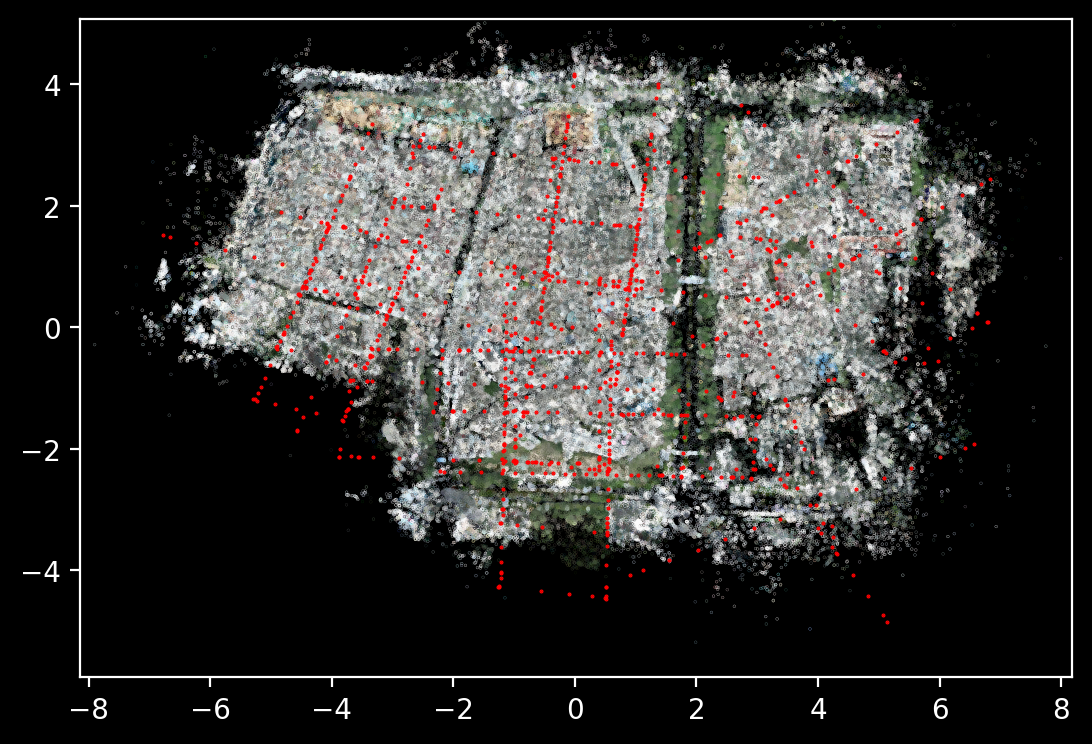

In [208]:
sparsify_points = 10
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
scene_size = torch.max(reoriented_camera_centers, dim=0).values - torch.min(reoriented_camera_centers, dim=0).values
ax.set_xlim([torch.min(reoriented_camera_centers[:, 0]) - 0.1 * scene_size[0], torch.max(reoriented_camera_centers[:, 0]) + 0.1 * scene_size[0]])
ax.set_ylim([torch.min(reoriented_camera_centers[:, 1]) - 0.1 * scene_size[1], torch.max(reoriented_camera_centers[:, 1]) + 0.1 * scene_size[1]])
ax.scatter(reoriented_point_cloud_xyz[::sparsify_points, 0], reoriented_point_cloud_xyz[::sparsify_points, 1], c=point_rgbs[::sparsify_points] / 255., s=0.01)
ax.scatter(reoriented_camera_centers[:, 0], reoriented_camera_centers[:, 1], s=0.2, c="red")
plt.show()

# 2. Build partitions

In [209]:
from internal.utils.citygs_partitioning_utils import CityGSSceneConfig, CityGSPartitionableScene

choose scene origin and partition size

In [210]:
scene_config = CityGSSceneConfig(
    origin=torch.tensor([0., 0.]),
    block_dim=[4, 2, 1],
)
scene = CityGSPartitionableScene(scene_config, reoriented_camera_centers[..., :2], reoriented_points=reoriented_point_cloud_xyz[..., :2])

calculate bounding box and number of partitions

In [211]:
scene.get_bounding_box_by_points()

MinMaxBoundingBox(min=tensor([-9.3159523010253906, -6.9746274948120117]), max=tensor([11.6835718154907227,  8.9827537536621094]))

In [212]:
scene.get_scene_bounding_box()

SceneBoundingBox(bounding_box=MinMaxBoundingBox(min=tensor([-9.3159523010253906, -6.9746274948120117]), max=tensor([11.6835718154907227,  8.9827537536621094])), n_partitions=tensor([4, 2, 1]), origin_partition_offset=None)

plot bounding box

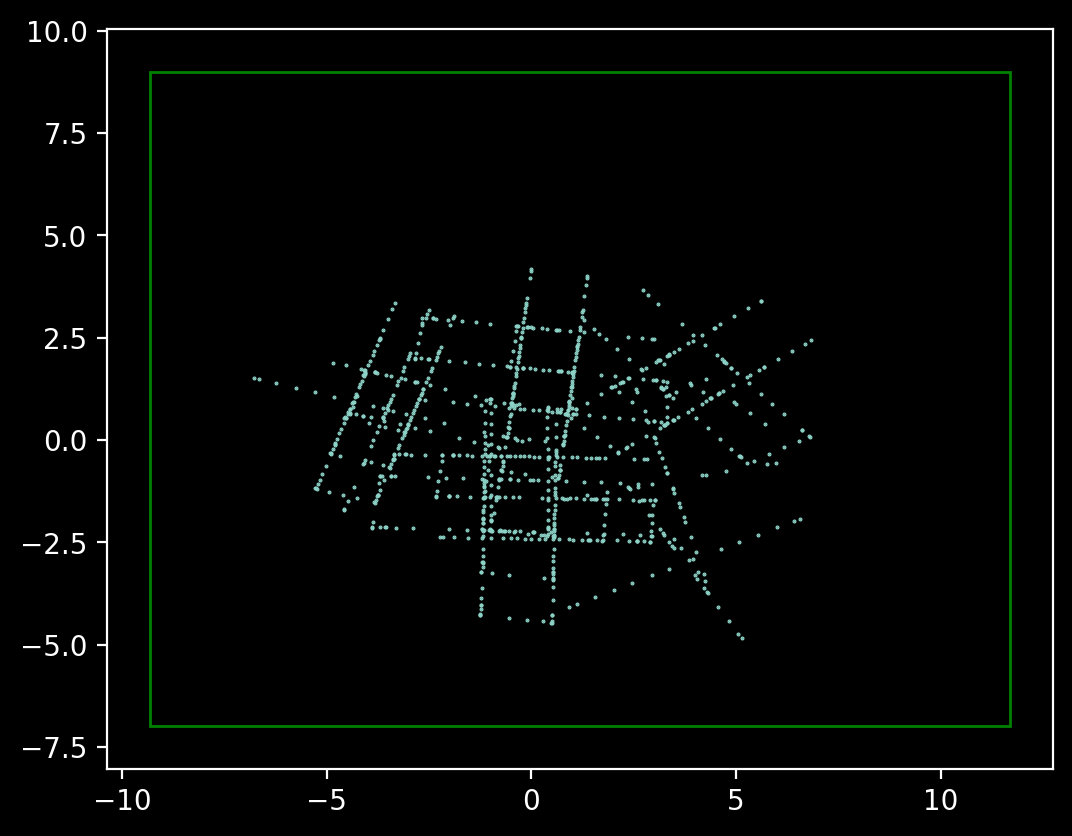

In [213]:
scene.plot(scene.plot_scene_bounding_box)

build partition coordinates

In [214]:
scene.build_partition_coordinates()

PartitionCoordinates(id=tensor([[0, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [0, 1],
        [1, 1],
        [2, 1],
        [3, 1]], dtype=torch.int32), xy=tensor([[-7.9558444023132324, -6.0731964111328125],
        [-2.2884747982025146, -6.0731964111328125],
        [-0.2022743672132492, -6.0731964111328125],
        [ 2.0368802547454834, -6.0731964111328125],
        [-7.9558444023132324,  1.0735149383544922],
        [-2.2884747982025146,  1.0735149383544922],
        [-0.2022743672132492,  1.0735149383544922],
        [ 2.0368802547454834,  1.0735149383544922]]))

plot partitions

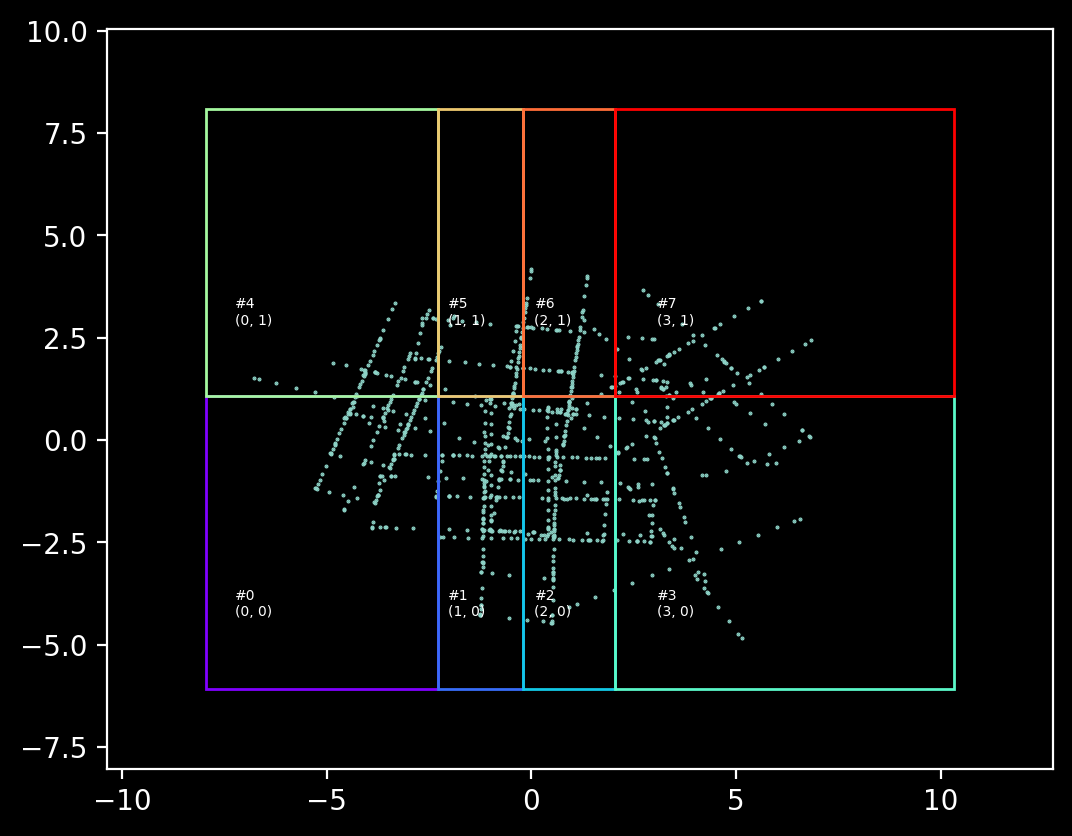

In [215]:
scene.plot(scene.plot_partitions)

# 3. Assign images to partitions

## 3.1. Location based assignment

In [216]:
scene_config.location_based_enlarge = 0.0

In [217]:
scene.camera_center_based_partition_assignment().sum(-1)

tensor([139, 192, 193, 146,  79,  51,  72,  86])

## 3.2. Visibility based assignment

the visibility is calculated from 3D points of every camera

assign cameras to partitions based on visibilities

In [218]:
scene.projection_based_partition_assignment(model, renderer, dataset.cameras, bkgd_color).sum(dim=-1)

block 0:   0%|          | 0/819 [00:00<?, ?it/s]

block 1:   0%|          | 0/766 [00:00<?, ?it/s]

block 2:   0%|          | 0/765 [00:00<?, ?it/s]

block 3:   0%|          | 0/812 [00:00<?, ?it/s]

block 4:   0%|          | 0/879 [00:00<?, ?it/s]

block 5:   0%|          | 0/907 [00:00<?, ?it/s]

block 6:   0%|          | 0/886 [00:00<?, ?it/s]

block 7:   0%|          | 0/872 [00:00<?, ?it/s]

tensor([ 99, 143, 155,  63, 163, 142, 160, 128])

# 4. Preview

In [221]:
output_path = os.path.join(dataset_path, scene.build_output_dirname())
try:
    assert os.path.exists(os.path.join(output_path, "partitions.pt")) is False
    if not os.path.exists(output_path):
        os.makedirs(output_path)
except:
    del output_path
    raise
output_path

'../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05'

In [222]:
max_plot_points = 51_200
plot_point_sparsify = max(reoriented_point_cloud_xyz.shape[0] // max_plot_points, 1)
plot_point_sparsify

178

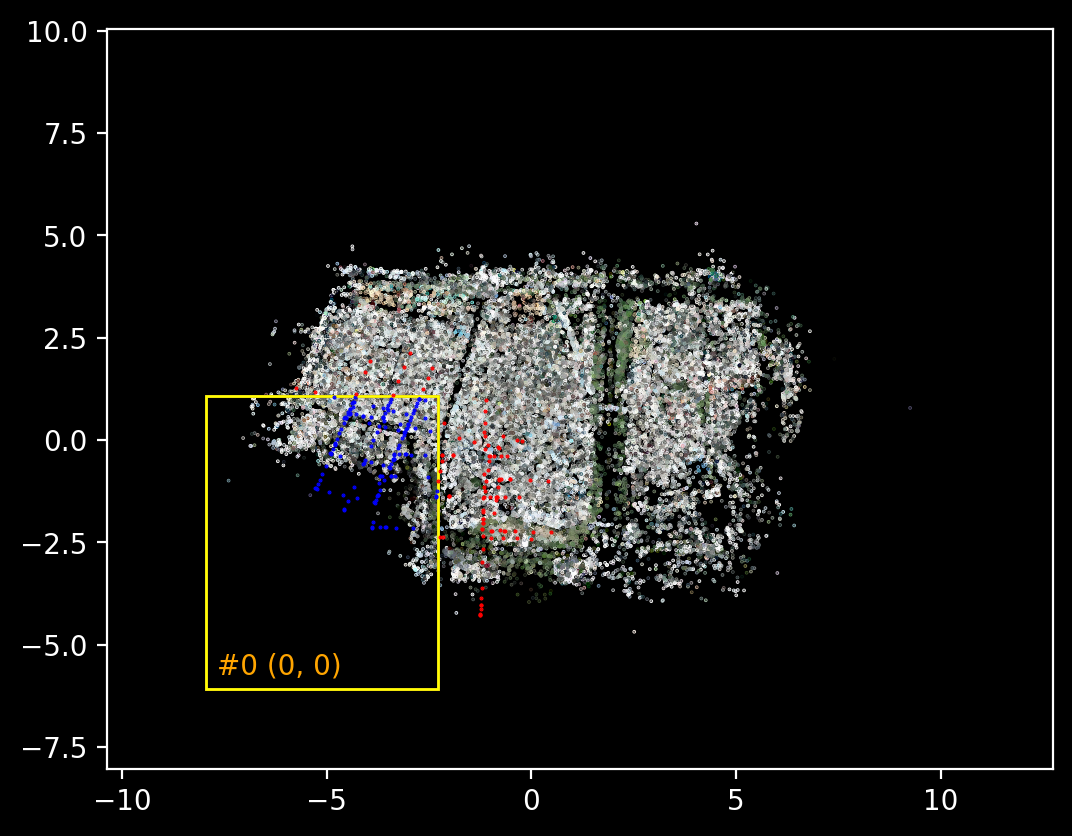

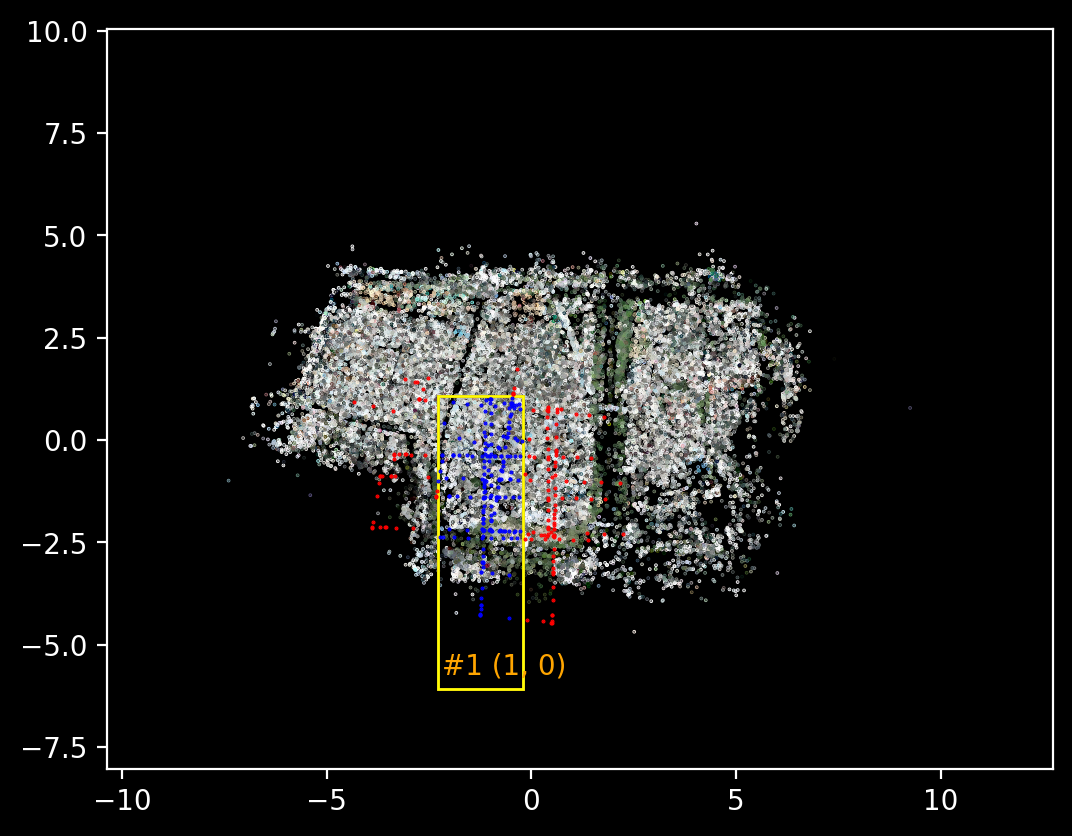

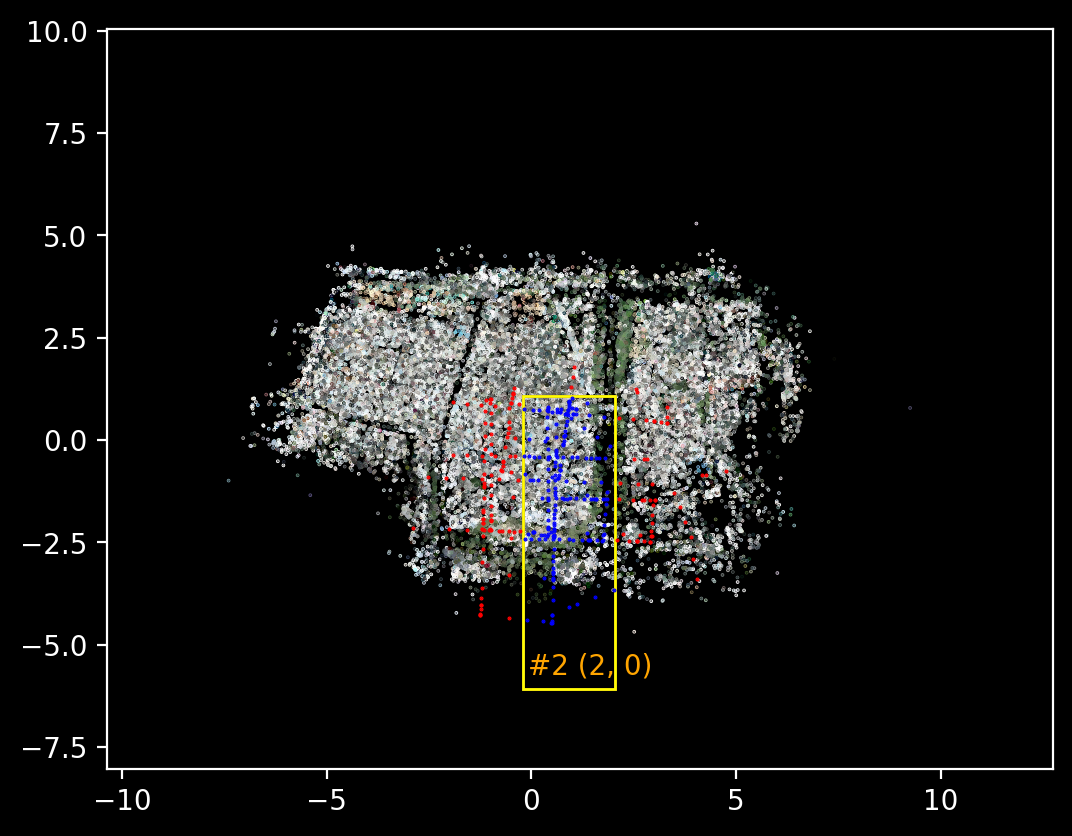

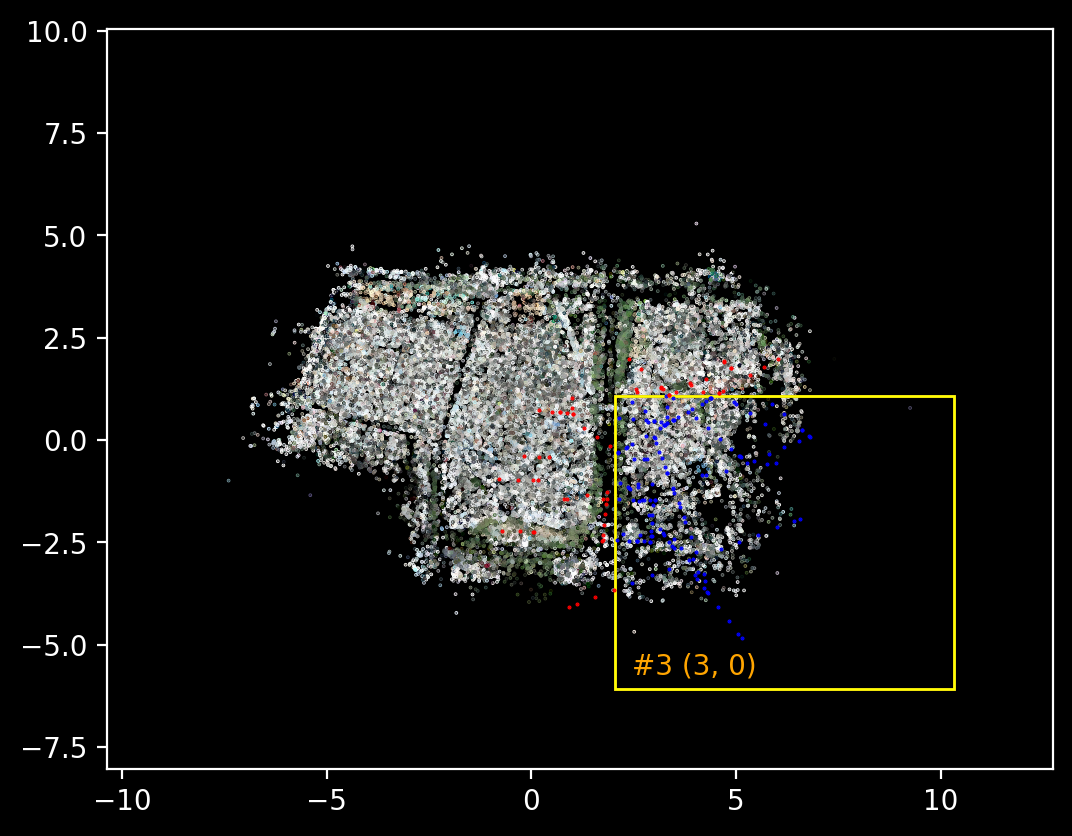

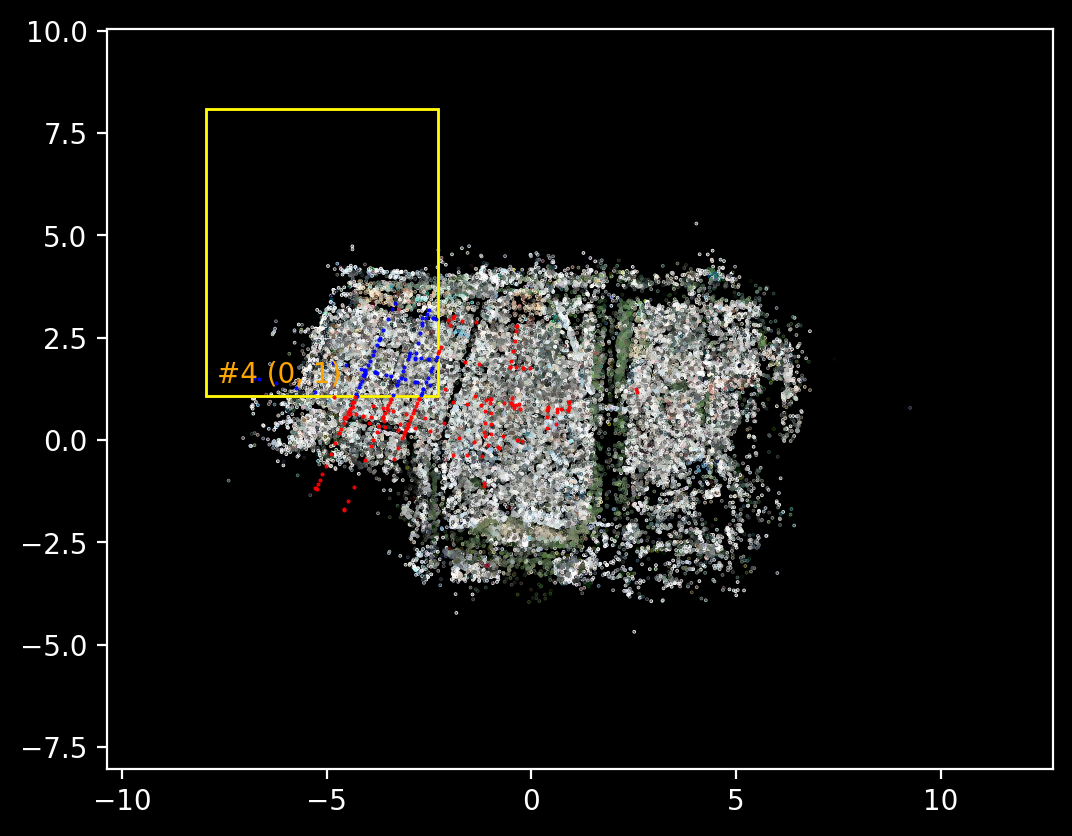

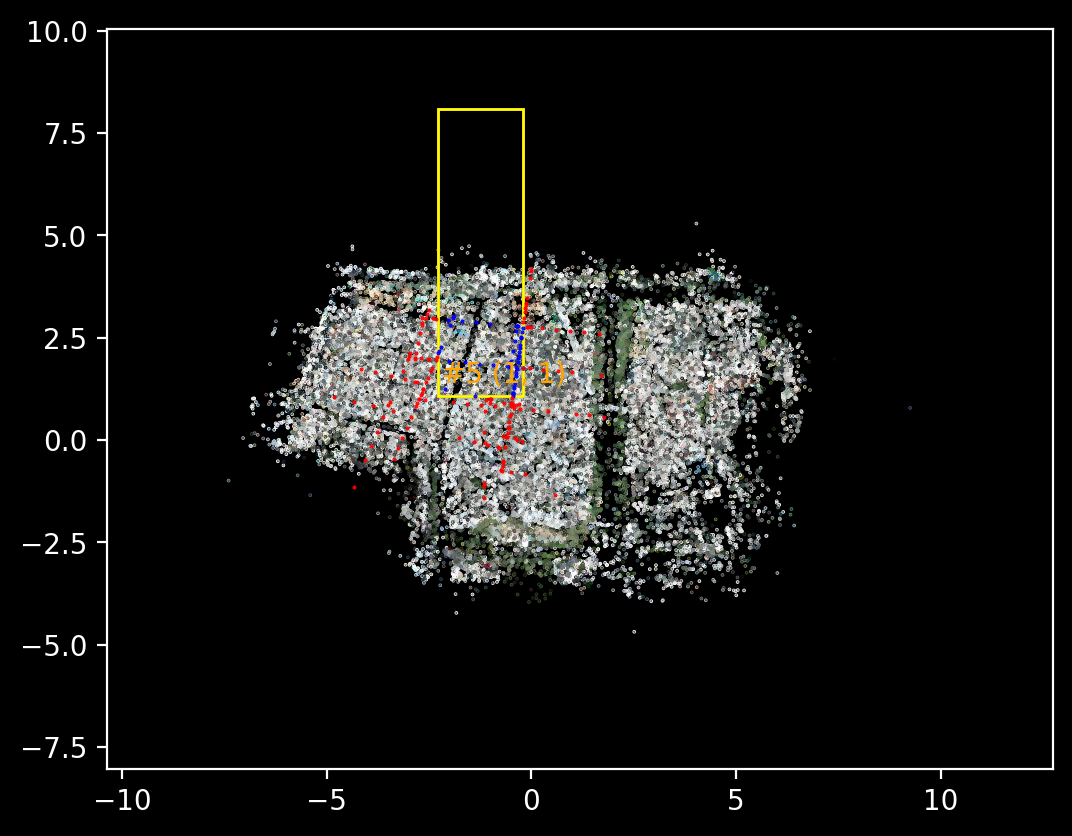

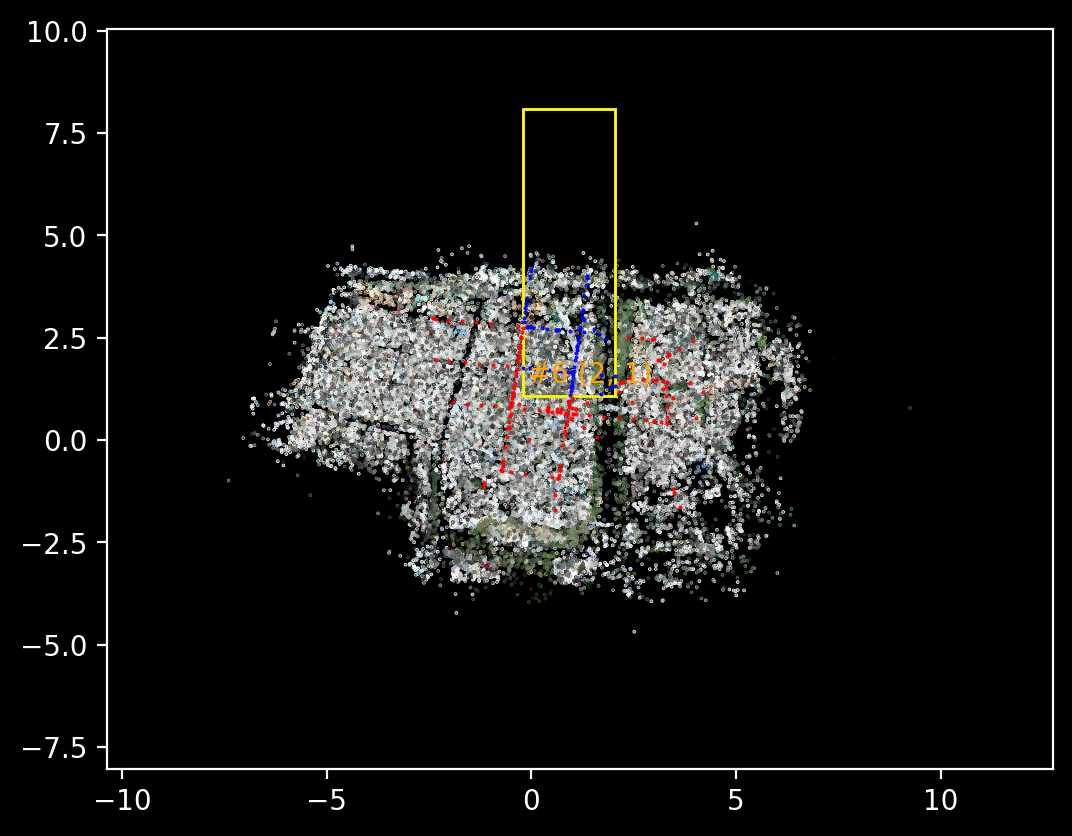

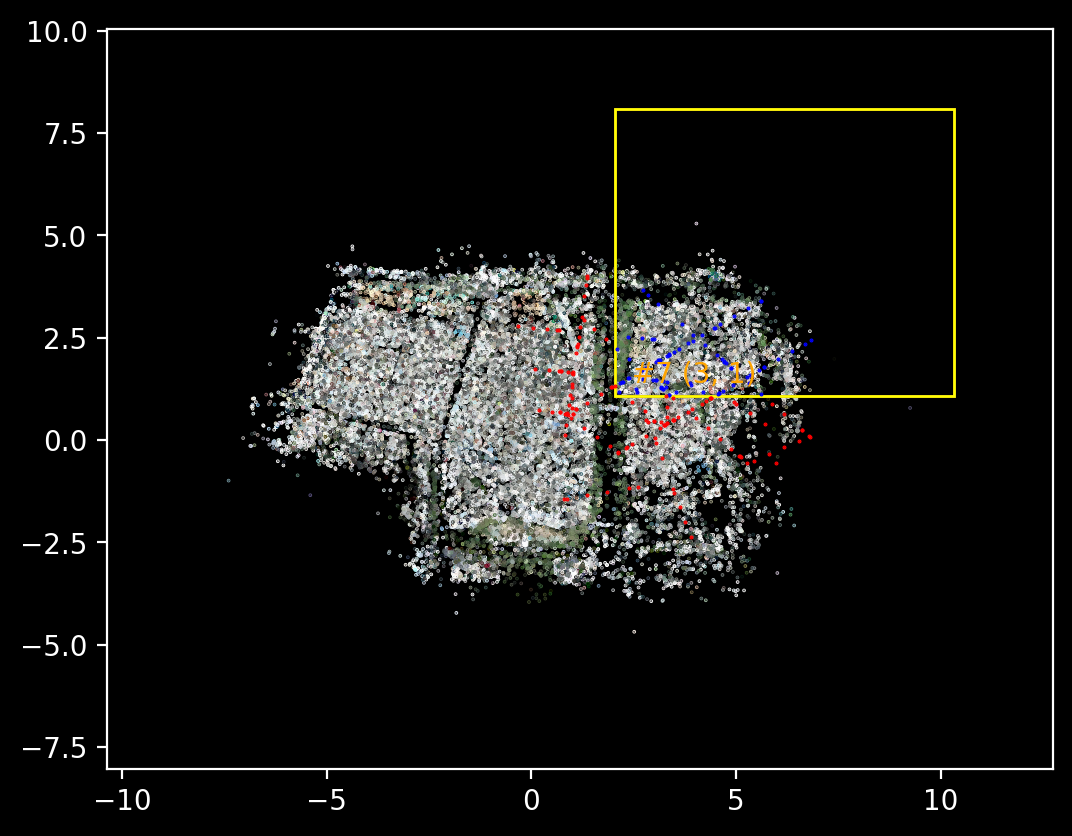

In [223]:
# plot the cameras assigned to the partitions
for idx in range(len(scene.partition_coordinates)):
    scene.save_plot(
        scene.plot_partition_assigned_cameras,
        os.path.join(output_path, "{}.png".format(scene.partition_coordinates.get_str_id(idx))),
        idx,
        reoriented_point_cloud_xyz,
        point_rgbs,
        point_sparsify=plot_point_sparsify,
    )
# scene.plot(scene.plot_partition_assigned_cameras, 13, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)
# scene.plot(scene.plot_partition_assigned_cameras, 15, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)

# 5. Saving

In [224]:
torch.load(scene.save(
    output_path,
    extra_data={
        "up": up,
        "rotation_transform": rotation_transform,
    }
))

{'scene_config': {'origin': tensor([0., 0.]),
  'block_dim': [4, 2, 1],
  'partition_size': tensor([[5.6673698425292969, 7.1467113494873047],
          [2.0862004756927490, 7.1467113494873047],
          [2.2391545772552490, 7.1467113494873047],
          [8.2865829467773438, 7.1467113494873047],
          [5.6673698425292969, 7.0078077316284180],
          [2.0862004756927490, 7.0078077316284180],
          [2.2391545772552490, 7.0078077316284180],
          [8.2865829467773438, 7.0078077316284180]]),
  'content_threshold': 0.05,
  'location_based_enlarge': 0.0,
  'visibility_based_enlarge': 0.0,
  'aabb': None,
  'num_threshold': None,
  'contract': False},
 'scene_bounding_box': {'bounding_box': {'min': tensor([-9.3159523010253906, -6.9746274948120117]),
   'max': tensor([11.6835718154907227,  8.9827537536621094])},
  'n_partitions': tensor([4, 2, 1]),
  'origin_partition_offset': None},
 'partition_coordinates': {'id': tensor([[0, 0],
          [1, 0],
          [2, 0],
          [

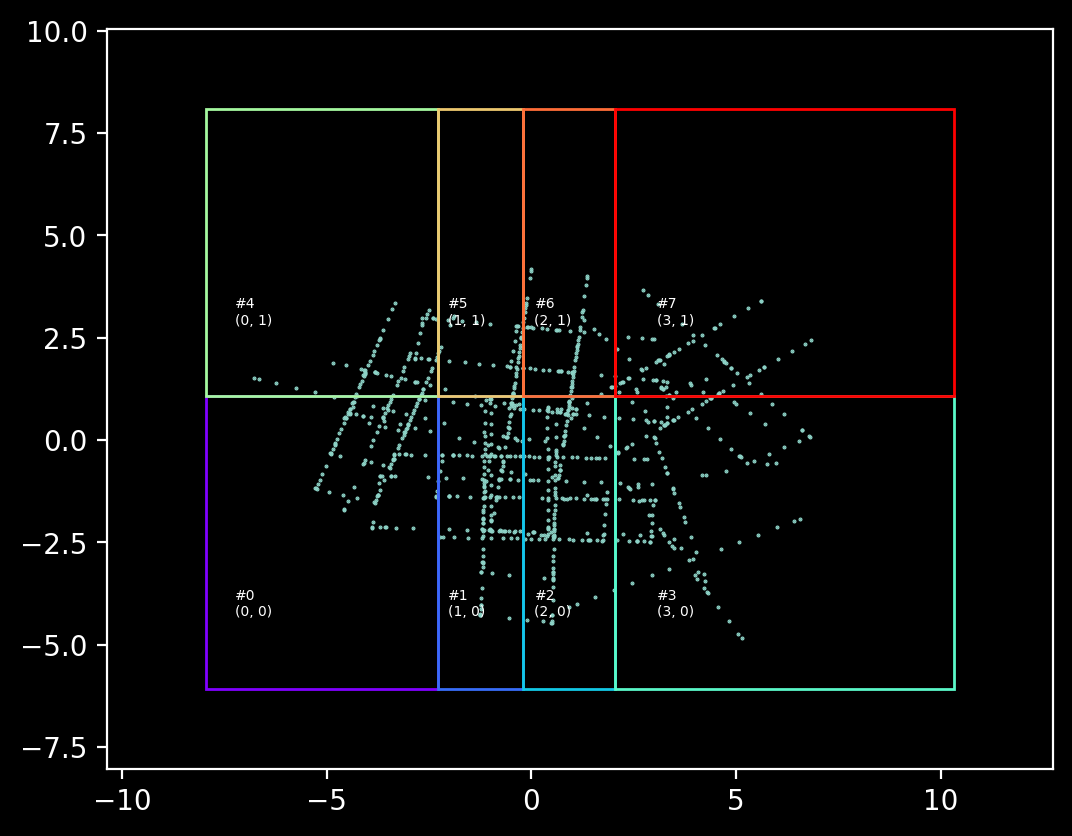

In [225]:
scene.save_plot(scene.plot_partitions, os.path.join(output_path, "partitions.png"))

In [226]:
# TODO: partitioning recursively on those that still contain a large number of images
# TODO: merge those with a small number of images into one of their neighbors
is_images_assigned_to_partitions = torch.logical_or(scene.is_camera_in_partition, scene.is_partitions_visible_to_cameras)
is_images_assigned_to_partitions.sum(-1)

tensor([238, 335, 348, 209, 242, 193, 232, 214])

write image lists

In [227]:
written_idx_list = []
for partition_idx in tqdm(list(range(is_images_assigned_to_partitions.shape[0]))):
    partition_image_indices = is_images_assigned_to_partitions[partition_idx].nonzero().squeeze(-1).tolist()
    if len(partition_image_indices) == 0:
        continue
        
    written_idx_list.append(partition_idx)
        
    camera_list = []
    
    with open(os.path.join(output_path, "{}.txt".format(scene.partition_coordinates.get_str_id(partition_idx))), "w") as f:
        for image_index in partition_image_indices:
            f.write(dataset.image_names[image_index])
            f.write("\n")
            
            # below camera list is just for visualization, not for training, so its camera intrinsics are fixed values
            color = [0, 0, 255]
            if scene.is_partitions_visible_to_cameras[partition_idx][image_index]:
                color = [255, 0, 0]
            camera_list.append({
                "id": image_index,
                "img_name": dataset.image_names[image_index],
                "width": 1920,
                "height": 1080,
                "position": c2w[image_index][:3, 3].numpy().tolist(),
                "rotation": c2w[image_index][:3, :3].numpy().tolist(),
                "fx": 1600,
                "fy": 1600,
                "color": color,
            })
            
    with open(os.path.join(
            output_path, 
            f"cameras-{scene.partition_coordinates.get_str_id(partition_idx)}.json",
    ), "w") as f:
        json.dump(camera_list, f, indent=4, ensure_ascii=False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [228]:
max_store_points = 512_000
store_point_step = max(point_rgbs.shape[0] // max_store_points, 1)
from internal.utils.graphics_utils import store_ply
store_ply(os.path.join(output_path, "points.ply"), model.get_xyz.to('cpu')[::store_point_step], point_rgbs[::store_point_step])

In [229]:
print("Run below commands to visualize the partitions in web viewer:\n")
for partition_idx in written_idx_list:
    id_str = scene.partition_coordinates.get_str_id(partition_idx)
    print("python utils/show_cameras.py \\\n    '{}' \\\n    --points='{}' \\\n --up {:.3f} {:.3f} {:.3f} \n".format(
        os.path.join(output_path, "cameras-{}.json".format(id_str)),
        os.path.join(output_path, "points.ply"),
        *(up.tolist()),
    ))

Run below commands to visualize the partitions in web viewer:

python utils/show_cameras.py \
    '../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05/cameras-000_000.json' \
    --points='../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05/points.ply' \
 --up -0.196 -0.718 -0.668 

python utils/show_cameras.py \
    '../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05/cameras-001_000.json' \
    --points='../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05/points.ply' \
 --up -0.196 -0.718 -0.668 

python utils/show_cameras.py \
    '../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05/cameras-002_000.json' \
    --points='../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibility_0.05/points.ply' \
 --up -0.196 -0.718 -0.668 

python utils/show_cameras.py \
    '../data/GauU_Scene/LFLS/partition/partitions-dim_4_2-contract_0_visibi